# NOTEBOOK

## Low rank approximation in Runge Kutta scheme for scientific applications

This notebook contains the code and all the plots from the thesis. 

___

First we need to import the necessary librairies

In [224]:
import numpy as np
import matplotlib.pyplot as plt

___

## Singular Values Decomposition (SVD)

The following implements the SVD decomposition of a matrix with a truncation to the rank r and return the approximation matrix of rank r. 

In [510]:
def svd_tronc(A,r):
    #INPUTS : 
    #A = matrix to troncate
    #r = rank 
    #OUTPUT : 
    #M = matrix final 
    
    U,D,Vt = np.linalg.svd(A, full_matrices=True)
    U=U[:,0:r] ; Vt=Vt[0:r,:] ; D=np.diag(D[0:r])
    finale=U@D@Vt
    
    return(finale)

The following returns the cost of the function svd_tronc.

In [511]:
def svd_tronc_cost(m,n,r):
    #INPUTS : 
    #m,n = dimension of the matrice
    #OUTPUT : 
    #cost
    
    cost=min(m*n**2,m**2*n)
    cost=cost+n*r**2+m*n*r
    
    return cost

___

## TCYU17

The following implements the TCYU17 algorithm.

In [697]:
def tcyu(M,r,k,l):
    #INPUTS : 
    #M = matrix to approximate
    #r = wanted rank
    #k,l = k<=l (parameter)
    #OUTPUTS : 
    #M_tilde = wanted matrix
    
    m=M.shape[0]
    n=M.shape[1]
    
    Y_tilde=np.random.normal(size=(l,m))
    Ω=np.random.normal(size=(k,n))
    
    X=Y_tilde@M
    Y=M@(Ω.conj().T)
    
    Q, R=np.linalg.qr(Y)
    
    B=np.linalg.lstsq(Y_tilde@Q, X,rcond=None)[0]
    
    U, D, Vh = np.linalg.svd(B, full_matrices=True)
    
    U=U[:,0:r] ; D=D[0:r] ; Vh=Vh[0:r,:] 
        
    Q_tilde=Q@U
        
    M_tilde=Q_tilde@np.diagflat(D)@Vh
            
    return(M_tilde,Q_tilde)

The following implements the cost function for the TCYU17 algorithm. 

In [513]:
def tcyu_cost(m,n,r,k,l):
    #INPUTS : 
    #m,n,r,k,l = dimensions
    #OUTPUT : 
    #cost
    
    step=[]
    
    step.append(m*l+n*k)
    step.append(m*n*l+m*n*k)
    
    step.append(2*m*k**2-2*k**3/3) #QR
    
    step.append(l*m**2) #Inside least square (lxm)
    
    step.append(2*l*k**2-2*k**3/3) #least square
    
    step.append(min(n**2*k,n*k**2)) #svd
    
    step.append(m*k*r) #consolidation
    
    step.append(m*r*n+n*r**2) #reconstruct
    
    return(sum(step))

___

## STA19 (TCYU19)

The following implements the STA algorithm.

In [695]:
def sta(r,A,k,s):
    #INPUTS:
    #r : truncated final rank
    #A : matrix to approximate (MxN)
    #Dim_redux : (KxM), (KxN), (SxM), (SxN)
    #OUTPUTS : 
    #A_tilda : approximate matrix of rank r0
    #////plan
    #1. recuperation of the dim_red from the array
    #2. capturing the range, corange, and the new whole 
    #3. qr to get the orthonormal matrix
    #4. least square
    #5. reconstruct the svd after troncature
    #6. reconstruction
    
    #1. recuption of the dim_red from the array and initiation of X,Y,Z,W
    #(KxM), (KxN), (SxM), (SxN)
    
    m,n =A.shape
    Y_=np.random.normal(size=(k,m)) ; Ω=np.random.normal(size=(k,n)) ; Φ=np.random.normal(size=(s,m)) ; Ψ=np.random.normal(size=(s,n))
    
    #2. capturing the range, corange, and the new whole 
    
    X=Y_@A ; Y=A@Ω.conj().T ; Z=Φ@A@(Ψ.conj().T) ; 
    
    #3. qr 
    
    Q=np.linalg.qr(Y)[0] ; P=np.linalg.qr(X.conj().T)[0]
    
    #4. least square
    
    C=np.linalg.lstsq(Φ@Q,Z, rcond=None)[0]
    
    C=(np.linalg.lstsq(Ψ@P,C.conj().T, rcond=None)[0]).conj().T
        
    #5. troncated svd + consolidation
       
    S, D, Vt=np.linalg.svd(C, full_matrices=True)
    S=S[:,0:r] ; D=np.diag(D[0:r]) ; Vt=Vt[0:r,:]
      
    S=Q@S ; Vt=Vt@(P.conj().T)
    
    
    #6. reconstruction
    
    Trunc_svd=[S,D,Vt]
    A_tilda=S@D@Vt
    
    return(A_tilda, Trunc_svd,Y_,Ω,Φ,Ψ)

The following implements the cost function for the STA algorithm.

In [525]:
def sta_cost(m,n,r,k,s):
    #INPUTS : 
    #m,n,r,k,s = dimensions
    #OUTPUT : 
    #cost
    
    step=[]
    step.append(m*s+n*k+n*s*m*k) #random
    
    step.append(2*m*n*k+m*n*s+s**2*m) #sketch
    
    step.append(2*m*k**2-2*k**3/3+2*n*k**2-2*k**3/3) #QR
    
    step.append(s*m*k+s*n*k) #inside least square
    
    step.append(2*(2*s*k**2-2*k**3/3)) #least square
    
    step.append(k**3) #svd
    
    step.append(m*k*r+r*k*n)
    
    step.append(r**2*n+m*r*n)
    
    return(sum(step))

___

### HMT11

The following implements HMT11 algorithm. 

In [526]:
def hmt_fixed_r(M,r,k,q):
    #INPUTS : 
    #M = Matrix MxN to approximate
    #r = final rank
    #k = dim redux size
    #q = parameter (0,1,2)
    #OUTPUTS : 
    #M_r = Matrix with approximated rank
    #U_r = troncated singular vector matrix
    
    m=M.shape[0]
    n=M.shape[1]

    Omega=np.random.normal(size=(n,k))
    
    if q==0:
        
        Y=M@Omega
    
    if q==1:
        
        Y=M@(M.conj().T@(M@Omega))
        
    if q==2:
        
        Y=M@(M.conj().T@(M@(M.conj().T@(M@Omega))))
             
    Q,R=np.linalg.qr(Y)
        
    B=Q.conj().T@M
        
    U,D,Vh=np.linalg.svd(B,full_matrices=True)
    
    U=U[:,0:r]
    
    D=D[0:r]
    
    Vh=Vh[0:r,:]

    U=Q@U
        
    M_r=U@np.diagflat(D)@Vh
        
    U_r=U
    
    return(M_r,U_r)

The following implements the cost function for HMT11 algorithm (for parameter q=1).

In [527]:
def hmt_cost(m,n,r,k,q):
    #INPUTS : 
    #m,n,r,k = dimensions
    #OUTPUT : 
    #cost
    
    step=[]
    step.append(n*k) #random
    
    step.append(2*q*m*n*k+m*n*k) # mult
    
    step.append(2*m*(k)**2-2*(k)**3/3) #qr
    
    step.append(k*m*n) #B
    
    step.append(min((k)**2*n,(k)*n**2)) #SVD
     
    step.append(m*(k)*r)
    
    step.append(r**2*n+m*r*n)
    
    return(sum(step))

___

## PLOT

The following implements a function to create three matrices which all have singular values decaying at different speed (very fast, fast, slow).

In [528]:
def fast_decay_mat(size):
    #INPUTS
    #size = (m,n)
    #OUTPUT
    #matrix with fast decaying singular values (2^-i)
    
    A=np.random.random(size)
    
    diag_vf=[2**-i for i in range(0, min(size))]
    diag_f=[1/(i+1) for i in range(0,min(size))]
    diag_slow=[1+1/(100*(i+1)) for i in range(0,min(size))]
    
    S,D,V=np.linalg.svd(A, full_matrices=True)
    
    Dvf=np.zeros(size) ; np.fill_diagonal(Dvf,diag_vf)
    Dv=np.zeros(size) ; np.fill_diagonal(Dv,diag_f)
    D_s=np.zeros(size) ; np.fill_diagonal(D_s,diag_slow)
    
    finalvf=S@Dvf@V.conj().T ; finalf = S@Dv@V.conj().T ; finalslow =S@D_s@V.conj().T
    
    return(finalvf,finalf,finalslow)

The following implements a function to compute the error for the different algorithm.

In [529]:
def err_computation(A,r_start,r_fin,k,s):
    #INPUTS :
    #A = matrix to approximate
    #r_start = starting rank
    #r_fin = ending rank + 1
    #k,s = parameters
    #OUTPUT : 
    #error arrays
    
    M_tcyu=[]
    M_svd=[]
    M_sta=[]
    M_hmt=[]

    #test
    for i in range(r_start,r_fin):
        T=tcyu(M,i,i+k,i+s)[0]
        S=svd_tronc(M,i)
        St=sta(i,M,i+k,i+s)[0]
        Ht=hmt_fixed_r(M,i,i+k,0)[0]
        M_tcyu.append(np.linalg.norm(T-M)/np.linalg.norm(M))
        M_svd.append(np.linalg.norm(S-M)/np.linalg.norm(M))
        M_sta.append(np.linalg.norm(St-M)/np.linalg.norm(M))
        M_hmt.append(np.linalg.norm(Ht-M)/np.linalg.norm(M))
    
    r_arr=[i for i in range(r_start,r_fin)]
        
    
    return(M_svd, M_tcyu, M_sta, M_hmt, r_arr)

The following function plot the result obtained with the last function.

In [584]:
def plot_err(result):
    #INPUTS :
    #result : SVD, TCYU, STA, HMT array
    #OUTPUTS : 
    #plot
    M_svd=result[0] ; M_tcyu=result[1] ; M_sta=result[2] ; M_hmt=result[3]
    
    #r array 
    
    r_arr=result[4];
    
    plt.semilogy(r_arr,M_tcyu,'--',label='TYUC17')
    plt.semilogy(r_arr,M_svd, label='SVDr')
    plt.semilogy(r_arr,M_sta,'--', label='STA19')
    plt.semilogy(r_arr,M_hmt,'--', label='HMT11')

    plt.legend()
    plt.show()

### Average

Implements a function that run the algorithm x times and do the average.

In [585]:
def average(M,r_start,r_fin,k,s,x):
    #INPUTS :
    #A = matrix to approximate
    #r_start = starting rank
    #r_fin = ending rank + 1
    #k,s = parameters
    #x = number of times
    #OUTPUT : 
    #error arrays
    
    M_tcyu=[]
    M_svd=[]
    M_sta=[]
    M_hmt=[]

    #test
    for i in range(r_start,r_fin):
        
        T_av=[]
        S_av=[]
        St_av=[]
        Ht_av=[]
        
        for c in range(x):
            
            
            T=tcyu(M,i,i+k,2*i+s)[0]
            S=svd_tronc(M,i)
            St=sta(i,M,i+k,2*i+s)[0]
            Ht=hmt_fixed_r(M,i,i+k,0)[0]
            
            T_av.append(np.linalg.norm(T-M)/np.linalg.norm(M))
            S_av.append(np.linalg.norm(S-M)/np.linalg.norm(M))
            St_av.append(np.linalg.norm(St-M)/np.linalg.norm(M))
            Ht_av.append(np.linalg.norm(Ht-M)/np.linalg.norm(M))
    

        M_tcyu.append(np.mean(T_av))
        M_svd.append(np.mean(S_av))
        M_sta.append(np.mean(St_av))
        M_hmt.append(np.mean(Ht_av))
        
    
    r_arr=[i for i in range(r_start,r_fin)]
        
    
    return(M_svd, M_tcyu, M_sta, M_hmt, r_arr)

Exponential decay (10 runs)

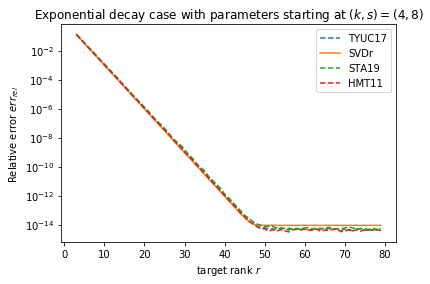

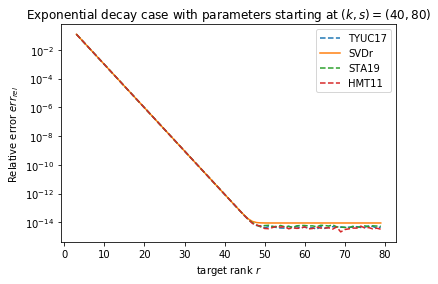

In [586]:
size=(500,500)
M=fast_decay_mat(size)
A=M[0]
k=4; s=8

result=average(A,3,80,k,s,10)
plt.figure()
plt.title('Exponential decay case with parameters starting at $(k,s)=(4,8)$')
plt.xlabel('target rank $r$')
plt.ylabel('Relative error $err_{rel}$')
plot_err(result)

k=40; s=80

result=average(A,3,80,k,s,10)
plt.figure()
plt.title('Exponential decay case with parameters starting at $(k,s)=(40,80)$')
plt.xlabel('target rank $r$')
plt.ylabel('Relative error $err_{rel}$')
plot_err(result)

Fast algebraic decay (10 runs)

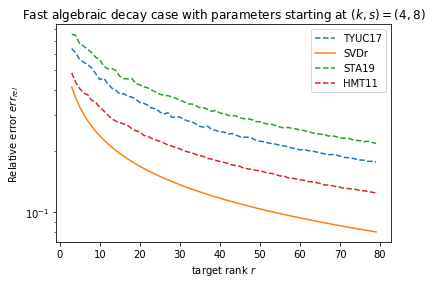

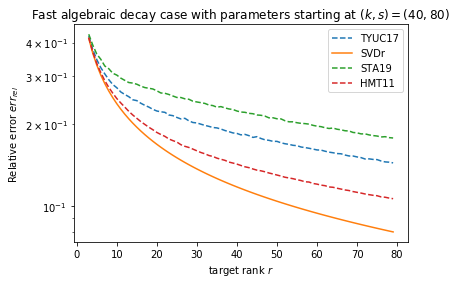

In [587]:
A=M[1]
k=4; s=8

result=average(A,3,80,k,s,10)
plt.figure()
plt.title('Fast algebraic decay case with parameters starting at $(k,s)=(4,8)$')
plt.xlabel('target rank $r$')
plt.ylabel('Relative error $err_{rel}$')
plot_err(result)

k=40; s=80

result=average(A,3,80,k,s,10)
plt.figure()
plt.title('Fast algebraic decay case with parameters starting at $(k,s)=(40,80)$')
plt.xlabel('target rank $r$')
plt.ylabel('Relative error $err_{rel}$')
plot_err(result)

Slow algebraic decaying (10 run)

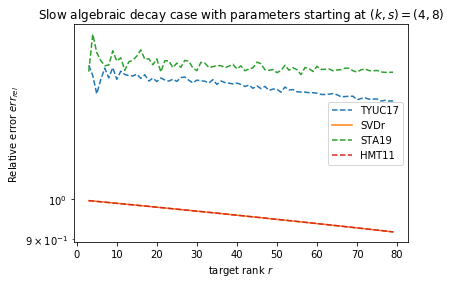

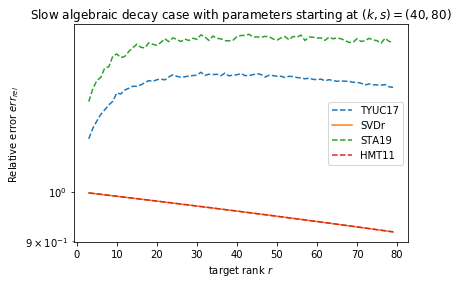

In [588]:
A=M[2]
k=4; s=8

result=average(A,3,80,k,s,10)
plt.figure()
plt.title('Slow algebraic decay case with parameters starting at $(k,s)=(4,8)$')
plt.xlabel('target rank $r$')
plt.ylabel('Relative error $err_{rel}$')
plot_err(result)

k=40; s=80

result=average(A,3,80,k,s,10)
plt.figure()
plt.title('Slow algebraic decay case with parameters starting at $(k,s)=(40,80)$')
plt.xlabel('target rank $r$')
plt.ylabel('Relative error $err_{rel}$')
plot_err(result)

___

## COST versus Error

The following implements a function that computes the error in function of the cost.

In [589]:
def err_storage_computation(M,r_start,r_fin,k,s):
    #INPUTS :
    #A = matrix to approximate
    #r_start = starting rank
    #r_fin = ending rank
    #k,s = parameters
    
    M_tcyu=[]
    M_svd=[]
    M_sta=[]
    M_hmt=[]
    
    size=A.shape
    m=size[0]
    n=size[1]

    stacost=[]
    hmtcost=[]
    svdcost=[]
    tcyucost=[]
    
    #test
    for i in range(r_start,r_fin):
        T=tcyu(M,i,i+k,2*i+s)[0]
        S=svd_tronc(M,i)
        St=sta(i,M,i+k,2*i+s)[0]
        Ht=hmt_fixed_r(M,i,i+k,0)[0]
        tcyucost.append(tcyu_cost(m,n,i,i+k,2*i+s))
        stacost.append(sta_cost(m,n,i,i+k,2*i+s))
        hmtcost.append(hmt_cost(m,n,i,i+k,0))
        svdcost.append(svd_tronc_cost(m,n,i))
        M_tcyu.append(np.linalg.norm(T-M)/np.linalg.norm(M))
        M_svd.append(np.linalg.norm(S-M)/np.linalg.norm(M))
        M_sta.append(np.linalg.norm(St-M)/np.linalg.norm(M))
        M_hmt.append(np.linalg.norm(Ht-M)/np.linalg.norm(M))
        
        
        
    
    return((M_svd, svdcost), (M_tcyu, tcyucost), (M_sta,stacost), (M_hmt, hmtcost))

The following implements a function that plot the result obtained before. 

In [590]:
def plot_err_cost(result):
    #INPUTS :
    #result : SVD, TCYU, STA, HMT array
    #res : difference between r_start and r_fin
    #OUTPUTS : 
    #plot
    M_svd=result[0] ; M_tcyu=result[1] ; M_sta=result[2] ; M_hmt=result[3]
    
    plt.semilogy(M_tcyu[1],M_tcyu[0],'--',label='TYUC17')
    #plt.semilogy(M_svd[1],M_svd[0], label='SVDr')
    plt.semilogy(M_sta[1],M_sta[0],'--', label='STA19')
    plt.semilogy(M_hmt[1],M_hmt[0],'--', label='HMT11')
    plt.legend()
    plt.show()

The following implements a function to have average over i runs

In [591]:
def average_cost(M,r_start,r_fin,k,s,x):
    #INPUTS :
    #A = matrix to approximate
    #r_start = starting rank
    #r_fin = ending rank + 1
    #k,s = parameters
    #x = number of times
    #OUTPUT : 
    #error arrays
    
    
    size=M.shape
    m=size[0]
    n=size[1]
    
    arr_tcyu=[]
    arr_svd=[]
    arr_sta=[]
    arr_hmt=[]
    
    
    for j in range(x):
        
        M_tcyu=[]
        M_svd=[]
        M_sta=[]
        M_hmt=[]


        stacost=[]
        hmtcost=[]
        svdcost=[]
        tcyucost=[]

        #test
        for i in range(r_start,r_fin):
            T=tcyu(M,i,k+i,2*i+s)[0]
            S=svd_tronc(M,i)
            St=sta(i,M,k+i,2*i+s)[0]
            Ht=hmt_fixed_r(M,i,k+i,0)[0]
            tcyucost.append(tcyu_cost(m,n,i,i+k,2*i+s))
            stacost.append(sta_cost(m,n,i,i+k,2*i+s))
            hmtcost.append(hmt_cost(m,n,i,i+k,0))
            svdcost.append(svd_tronc_cost(m,n,i))
            M_tcyu.append(np.linalg.norm(T-M)/np.linalg.norm(M))
            M_svd.append(np.linalg.norm(S-M)/np.linalg.norm(M))
            M_sta.append(np.linalg.norm(St-M)/np.linalg.norm(M))
            M_hmt.append(np.linalg.norm(Ht-M)/np.linalg.norm(M))
        
        arr_tcyu.append(M_tcyu)
        arr_svd.append(M_svd)
        arr_sta.append(M_sta)
        arr_hmt.append(M_hmt)
        

    F_tcyu=np.mean(arr_tcyu,axis=0)
    F_svd=np.mean(arr_svd,axis=0)
    F_sta=np.mean(arr_sta,axis=0)
    F_hmt=np.mean(arr_hmt,axis=0)
    
        
    
    return((F_svd, svdcost), (F_tcyu, tcyucost), (F_sta,stacost), (F_hmt, hmtcost))

Result for exponential decay and fast algebraic decay.

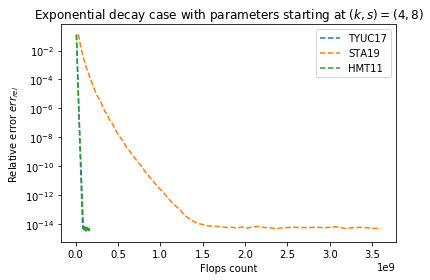

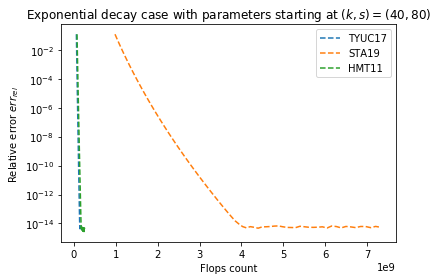

In [592]:
size=(500,500)
M=fast_decay_mat(size)
A=M[0]
a=average_cost(A,3,80,4,8,10)
plt.figure()
plt.title('Exponential decay case with parameters starting at $(k,s)=(4,8)$')
plt.xlabel('Flops count')
plt.ylabel('Relative error $err_{rel}$')
plot_err_cost(a)

a=average_cost(A,3,80,40,80,10)
plt.figure()
plt.title('Exponential decay case with parameters starting at $(k,s)=(40,80)$')
plt.xlabel('Flops count')
plt.ylabel('Relative error $err_{rel}$')
plot_err_cost(a)

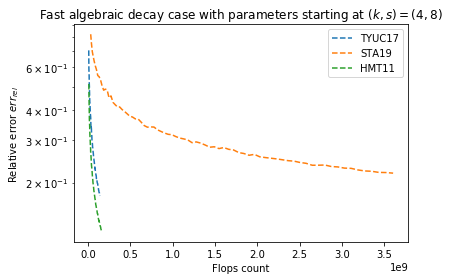

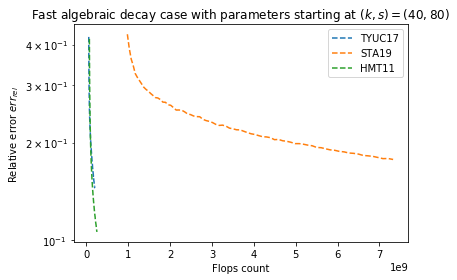

In [593]:
A=M[1]
a=average_cost(A,3,80,4,8,10)
plt.figure()
plt.title('Fast algebraic decay case with parameters starting at $(k,s)=(4,8)$')
plt.xlabel('Flops count')
plt.ylabel('Relative error $err_{rel}$')
plot_err_cost(a)

a=average_cost(A,3,80,40,80,10)
plt.figure()
plt.title('Fast algebraic decay case with parameters starting at $(k,s)=(40,80)$')
plt.xlabel('Flops count')
plt.ylabel('Relative error $err_{rel}$')
plot_err_cost(a)

___

## Time vs Error

In [594]:
from timeit import default_timer as timer

We modifiy lightly the same function as before

In [597]:
def plot_err_time(result):
    #INPUTS :
    #result : SVD, TCYU, STA, HMT array
    #res : difference between r_start and r_fin
    #OUTPUTS : 
    #plot
    M_svd=result[0] ; M_tcyu=result[1] ; M_sta=result[2] ; M_hmt=result[3]
    
    plt.semilogy(M_tcyu[1],M_tcyu[0],'--',label='TYUC17')
    #plt.semilogy(M_svd[1],M_svd[0], label='SVDr')
    plt.semilogy(M_sta[1],M_sta[0],'--', label='STA19')
    plt.semilogy(M_hmt[1],M_hmt[0],'--', label='HMT11')
    plt.legend()
    plt.show()

In [598]:
def average_time(M,r_start,r_fin,k,s,x):
    #INPUTS :
    #A = matrix to approximate
    #r_start = starting rank
    #r_fin = ending rank + 1
    #k,s = parameters
    #x = number of times
    #OUTPUT : 
    #error arrays
    
    
    size=M.shape
    m=size[0]
    n=size[1]
    
    arr_tcyu=[]
    arr_svd=[]
    arr_sta=[]
    arr_hmt=[]
    
    Tcyu_time=[]
    Svd_time=[]
    Sta_time=[]
    Hmt_time=[]
    
    
    for j in range(x):
        
        M_tcyu=[]
        M_svd=[]
        M_sta=[]
        M_hmt=[]


        statime=[]
        hmttime=[]
        svdtime=[]
        tcyutime=[]

        #test
        for i in range(r_start,r_fin):
            start=timer()
            T=tcyu(M,i,i+k,2*i+s)[0]
            end=timer()
            tcyu_t=end-start

            start=timer()        
            S=svd_tronc(M,i)
            end=timer()
            svd_t=end-start

            start=timer()
            St=sta(i,M,i+k,2*i+s)[0]
            end=timer()
            sta_t=end-start

            start=timer()
            Ht=hmt_fixed_r(M,i,i+k,0)[0]
            end=timer()
            hmt_t=end-start

            tcyutime.append(tcyu_t)
            statime.append(sta_t)
            hmttime.append(hmt_t)
            svdtime.append(svd_t)
            M_tcyu.append(np.linalg.norm(T-M)/np.linalg.norm(M))
            M_svd.append(np.linalg.norm(S-M)/np.linalg.norm(M))
            M_sta.append(np.linalg.norm(St-M)/np.linalg.norm(M))
            M_hmt.append(np.linalg.norm(Ht-M)/np.linalg.norm(M))
        
        arr_tcyu.append(M_tcyu)
        arr_svd.append(M_svd)
        arr_sta.append(M_sta)
        arr_hmt.append(M_hmt)
        Tcyu_time.append(tcyutime)
        Sta_time.append(statime)
        Hmt_time.append(hmttime)
        Svd_time.append(svdtime)
        

    F_tcyu=np.mean(arr_tcyu,axis=0)
    F_svd=np.mean(arr_svd,axis=0)
    F_sta=np.mean(arr_sta,axis=0)
    F_hmt=np.mean(arr_hmt,axis=0)
    
    T_tcyu=np.mean(Tcyu_time,axis=0)
    T_svd=np.mean(Svd_time,axis=0)
    T_sta=np.mean(Sta_time,axis=0)
    T_hmt=np.mean(Hmt_time,axis=0)
    
        
    
    return((F_svd, T_svd), (F_tcyu, T_tcyu), (F_sta,T_sta), (F_hmt, T_hmt))

We look at the result for a (500,500) matrix (rank 3 to 40)

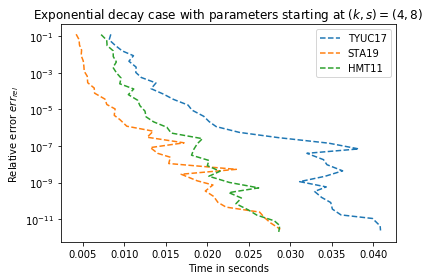

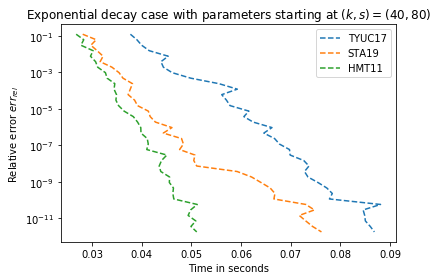

In [599]:
size=(500,500)
M=fast_decay_mat(size)
A=M[0]
a=average_time(A,3,40,4,8,10)
plt.figure()
plt.title('Exponential decay case with parameters starting at $(k,s)=(4,8)$')
plt.xlabel('Time in seconds')
plt.ylabel('Relative error $err_{rel}$')
plot_err_time(a)

a=average_time(A,3,40,40,80,10)
plt.figure()
plt.title('Exponential decay case with parameters starting at $(k,s)=(40,80)$')
plt.xlabel('Time in seconds')
plt.ylabel('Relative error $err_{rel}$')
plot_err_time(a)

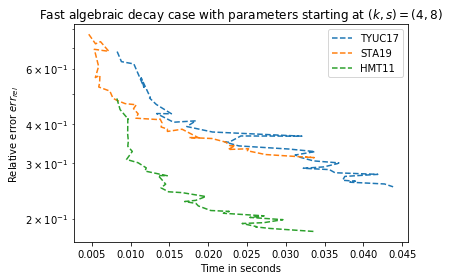

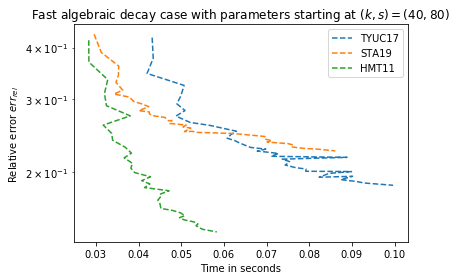

In [600]:
A=M[1]
a=average_time(A,3,40,4,8,10)
plt.figure()
plt.title('Fast algebraic decay case with parameters starting at $(k,s)=(4,8)$')
plt.xlabel('Time in seconds')
plt.ylabel('Relative error $err_{rel}$')
plot_err_time(a)

a=average_time(A,3,40,40,80,10)
plt.figure()
plt.title('Fast algebraic decay case with parameters starting at $(k,s)=(40,80)$')
plt.xlabel('Time in seconds')
plt.ylabel('Relative error $err_{rel}$')
plot_err_time(a)

___

# BOUNDS STUDY

In the following we study the different bound proposed

Matrix to test

In [601]:
(m,n)=(500,500)
M=fast_decay_mat((m,n))

### HMT11 bound

In [ ]:
r_start, r_fin = 3,40
final_norm=[] ; RHS=[] ; r_array=[]
j=1; q=0 ; x=10; 
for r in range(r_start, r_fin):
        mean_norm=[]
        for i in range(x):
            evaluation=np.linalg.norm(M[j]-hmt_fixed_r(M[j],r,2*r,q)[0],ord=2)
            mean_norm.append(evaluation)
        final_norm.append((1/x)*np.sum(mean_norm,axis=0))
        val=np.sum(np.linalg.svd(M[j])[1][r])
        const=(1+4*(2*min(m,n)/(2*r-1))**(1/2))**(1/(2*q+1))
        RHS.append(val+const*val)
        r_array.append(r)

In [ ]:
plt.figure()
plt.semilogy(r_array,RHS, label="Bound")
plt.semilogy(r_array,final_norm,'--',label="Expectation")
plt.legend()
plt.title('Exponential decay')
plt.xlabel('target rank $r$')

### TYUC17 bound

We first look at the general error

We define the tail energy fonction

In [607]:
def tail_energy(A,n):
    return(sum(np.square((np.linalg.svd(A)[1])[n:])))

We need to define a fonction that find the min with bruteforce.

In [608]:
def find_min(k,a,A):
    bound=k-a
    result=[]
    for L in range(bound):
        c=k/(k-L-a)
        t=tail_energy(A,L)
        result.append(c*t)
    return(min(result))   

Now we look at the truncated error

In [721]:
def find_min_2(k,a,A):
    bound=k-a
    result=[]
    for L in range(1,bound):
        c=(1+L/(k-L-a))**(1/2)
        t=tail_energy(A,L)**(1/2)
        result.append(c*t)
    return(min(result))   

In [723]:
r_start, r_fin = 3,40
final_norm=[] ; RHS=[] ; r_array=[]
j=0; a = 1 ; k = 40 ; l=80
for r in range(r_start, r_fin):
        mean_norm=[]
        for i in range(x):
            l=2*(k+r)
            evaluation=np.linalg.norm(M[j]-tcyu(M[j],r,k+r,l+r)[0])
            mean_norm.append(evaluation)
        final_norm.append((1/x)*np.sum(mean_norm,axis=0))
        svd=tail_energy(M[j],r)**(1/2)
        c=2*((1+k/(l-k-a))**(1/2))
        c_2=find_min_2(k,a,M[j])
        RHS.append(svd+c*c_2)
        r_array.append(r)

Text(0.5,0,'target rank $r$')

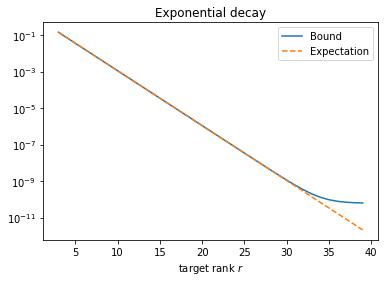

In [724]:
plt.figure()
plt.semilogy(r_array,RHS, label="Bound")
plt.semilogy(r_array,final_norm,'--',label="Expectation")
plt.legend()
plt.title('Exponential decay')
plt.xlabel('target rank $r$')

In [725]:
r_start, r_fin = 3,40
final_norm=[] ; RHS=[] ; r_array=[]
j=1; a = 1 ; k = 40 ; l=80
for r in range(r_start, r_fin):
        mean_norm=[]
        for i in range(x):
            l=2*(k+r)
            evaluation=np.linalg.norm(M[j]-tcyu(M[j],r,k+r,l+r)[0])
            mean_norm.append(evaluation)
        final_norm.append((1/x)*np.sum(mean_norm,axis=0))
        svd=tail_energy(M[j],r)**(1/2)
        c=2*((1+k/(l-k-a))**(1/2))
        c_2=find_min_2(k,a,M[j])
        RHS.append(svd+c*c_2)
        r_array.append(r)

Text(0.5,0,'target rank $r$')

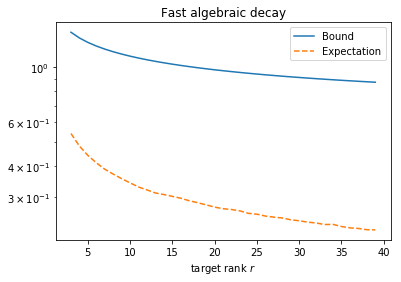

In [726]:
plt.figure()
plt.semilogy(r_array,RHS, label="Bound")
plt.semilogy(r_array,final_norm,'--',label="Expectation")
plt.legend()
plt.title('Fast algebraic decay')
plt.xlabel('target rank $r$')

### STA19 bound

We look at the truncated result

In [729]:
def find_min_3(k,a,A):
    bound=k-a
    result=[]
    for L in range(bound):
        c=(k+L-a)/(k-L-a)
        t=tail_energy(A,L)
        result.append(c*t)
    return(min(result))   

In [735]:
r_start, r_fin = 3,40
final_norm=[] ; RHS=[] ; r_array=[]
j=1; a = 1 ; k = 40 ; s=80 ; 
for r in range(r_start, r_fin):
        mean_norm=[]
        for i in range(x):
            l=2*(k+r)
            evaluation=np.linalg.norm(M[j]-sta(r,M[j],k+r,s+2*r)[0],ord=2)
            mean_norm.append(evaluation**2)
        final_norm.append((1/x)*np.sum(mean_norm,axis=0))
        svd=tail_energy(M[j],r)**(1/2)
        c=(s-a)/(s-k-a)
        c_2=find_min_3(k,a,M[j])
        RHS.append(svd+2*(c*c_2)**(1/2))
        r_array.append(r)

Text(0.5,0,'target rank $r$')

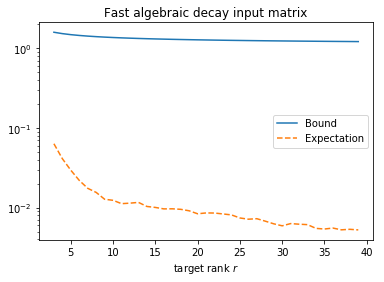

In [736]:
plt.figure()
plt.semilogy(r_array,RHS, label="Bound")
plt.semilogy(r_array,final_norm,'--',label="Expectation")
plt.legend()
plt.title('Fast algebraic decay input matrix')
plt.xlabel('target rank $r$')

In [737]:
r_start, r_fin = 3,40
final_norm=[] ; RHS=[] ; r_array=[]
j=0; a = 1 ; k = 40 ; s=80 ; 
for r in range(r_start, r_fin):
        mean_norm=[]
        for i in range(x):
            l=2*(k+r)
            evaluation=np.linalg.norm(M[j]-sta(r,M[j],k+r,s+2*r)[0],ord=2)
            mean_norm.append(evaluation**2)
        final_norm.append((1/x)*np.sum(mean_norm,axis=0))
        svd=tail_energy(M[j],r)**(1/2)
        c=(s-a)/(s-k-a)
        c_2=find_min_3(k,a,M[j])
        RHS.append(svd+2*(c*c_2)**(1/2))
        r_array.append(r)

Text(0.5,0,'target rank $r$')

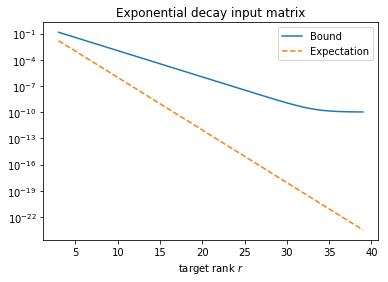

In [738]:
plt.figure()
plt.semilogy(r_array,RHS, label="Bound")
plt.semilogy(r_array,final_norm,'--',label="Expectation")
plt.legend()
plt.title('Exponential decay input matrix')
plt.xlabel('target rank $r$')

# TENSOR

Essential librairies

In [643]:
from tensorly import tucker_to_tensor, unfold, norm
from tensorly.tenalg import mode_dot

___

Creation of Data

In [644]:
def datacreation(dim_c,dim_t,diag_value):
    #INPUTS 
    #dim_c : dimension of the core
    #dim_t : dimension of the tensor
    #diag_value : array of the correct dimension containing the diagonal values
    #OUTPUTS
    #return (tensor,cube) and plot the singular value
    
    #diagonal 
    
    core=np.zeros(dim_c)

    alpha=np.min(dim_c)

    for i in range(0,alpha):
    
        core[i,i,i]=diag_value[i]
    
    #size
    
    k,n,m=dim_c
    i,j,l=dim_t
    
    a=(i,k) ; b=(j,n) ; c=(l,m)

    M1=np.random.normal(0,1,a) ; M2=np.random.normal(0,1,b) ; M3=np.random.normal(0,1,c)
    M_1=np.linalg.qr(M1)[0] ; M_2=np.linalg.qr(M2)[0] ; M_3=np.linalg.qr(M3)[0] 

    #building the tensor back

    Tens_2=mode_dot(core, M_1, 0)
    Tens_1=mode_dot(Tens_2,M_2,1)

    #final Tensor

    Tens_Finale=mode_dot(Tens_1,M_3,2)
    print('shape of cube')
    print(core.shape)
    print('shape of tensor')
    print(Tens_Finale.shape)
    
    plt.semilogy(diag_value)
    
    return(Tens_Finale,core,diag_value) 

Reconstruction

In [749]:
def reconstruct(T, U):
    #INPUT :
    #T = tensor to approximate
    #U = matrix of reconstruction
    #mode : 0, 1, 2 
    #OUTPUT : 
    #T_tilda=tensor approximation
    
    size=len(T.shape)
    
    U_T=[]
    for i in range(0,size):
        U_T.append(np.transpose(U[i]))
    
    #reconstruction
    
    for i in range(0,size):
        alpha=U_T[i]
        T_tilda=mode_dot(T,alpha,i)
        beta=U[i]
        T_tilda=mode_dot(T_tilda,beta,i)
        T=T_tilda

    
    return(T_tilda)

HOSVD

In [646]:
def hosvd(X, rank):
    #HIGH ORDER SVD ALGORITHME 1#INPUTS 
    #INPUTS 
    #X : Tensors
    #rank : Aimed Rank (array)
    #OUPUT
    #Core, Low rank approximation matrices

    #Unfolding
    A=[]
    for i in range(0,len(X.shape)):
        A.append(unfold(X, i))
    
    B=[]
    #Selection rank singular vector
    for i in range(0, len(X.shape)):
        U, D, V = np.linalg.svd(A[i], full_matrices=True, compute_uv=True)
        B.append(U[:,0:rank[i]])
    
    #reconstruction
    for i in range(0,len(X.shape)):
        C=mode_dot(X, np.transpose(B[i]),i)
        X=C
    
    return(X,B)

Cost function, only work for 3d tensors with the same dimension for all the slices 

In [647]:
def cost_hosvd(m,n,r):
        
    cost=min(m*n**2,m**2*n)
    cost=cost+n*r**2+m*n*r
    cost=3*cost
    
    return cost

HMT11

In [648]:
def hmt_rank(X, r0,k,q):
    #INPUTS : 
    #X : tensors
    #r0 : array of desired rank for troncation
    #k : parameter for dim redux matrix
    #q : power for the Htm algorithm
    
    #OUTPUT : 
    #Core, low rank approximation matrices
    

    #Unfolding of the tensors
    
    A=[]
    for i in range(0,len(X.shape)):
        A.append(unfold(X, i))


    
    svd=[]
    for i in range(0,len(X.shape)):
        svd.append(hmt_fixed_r(A[i],r0[i],k,q)[1])

    
    #Reconstruction

    for i in range(0,len(X.shape)):
        C=mode_dot(X, np.transpose(svd[i]),i)
        X=C
        
    #Results

    return(C,svd)

Cost function, only work for 3d tensors with the same dimension for all the slices 

In [649]:
def hmt_cost(m,n,r,k,q):
    step=[]
    step.append(n*k) #random
    
    step.append(2*q*m*n*k+m*n*k) # mult
    
    step.append(2*m*(k)**2-2*(k)**3/3) #qr
    
    step.append(k*m*n) #B
    
    step.append(min((k)**2*n,(k)*n**2)) #SVD
     
    step.append(m*(k)*r)
        
    step=sum(step)
    
    return(3*step)

TYUC17

In [650]:
def tcyu_tensor(X_1,dim_array,rdim,mu,sigma):
    #INPUTS: 
    #X = tensors
    #dim = (k,n)x2*(dim of the tensor) = dimT*2 for dimension reduction map
    #rdim = vector of dimension of rank for the svd (troncature)
    #mu , sigma = parameter for the gaussian matrix
    #OUTPUT:
    #Core, low rank approximation matrices
    
    #STEP 1: getting the number of mode the tensor
    
    size=len(X_1.shape)
    
    #STEP 2: unfolding the tensor
    
    Unfolded=[]
    for i in range(0,size):
        Unfolded.append(unfold(X_1, i))
    
    #STEP 3 : creating Dim Redux
    
    #Recuperation des dimensions

    DIM=[]
    for i in range(0,len(X_1.shape)):
        DIM.append(Unfolded[i].shape)
        
    #STA19 applied to the matrization
    
    Reconstruct=[]

    for i in range(0,len(X_1.shape)):
        
        #matrix to apply the dim_red
        
        M=Unfolded[i]
        
        k,s=dim_array[i]
        
        #extraction of dimension reduction map from the array
        
        res=tcyu(M,rdim[i],k,s)[1]
        
        Reconstruct.append(res)
    
    #Reconstruction of the tensor
    
    for i in range(0,3):

        C=mode_dot(X_1, np.transpose(Reconstruct[i]),i)

        X_1=C
    

    
    #Results
    
    return(C,Reconstruct)

Cost function, only work for 3d tensors with the same dimension for all the slices 

In [651]:
def cost_tcyu(m,n,r,k,s):
    
    
    step=[]
    
    step.append(m*l+n*k)
    step.append(m*n*l+m*n*k)
    
    step.append(2*m*k**2-2*k**3/3) #QR
    
    step.append(l*m**2) #Inside least square (lxm)
    
    step.append(2*l*k**2-2*k**3/3) #least square
    
    step.append(min(n**2*k,n*k**2)) #svd
    
    step.append(m*k*r) #consolidation
    
    step=sum(step)
    
    step=3*step
    
    return(step)

STA19

In [652]:
def STA_tensor(X_1,dim_array,rdim,mu,sigma):
    #INPUTS: 
    #X = tensors
    #dim = (k,n)x2*(dim of the tensor) = dimT*2 for dimension reduction map
    #rdim = vector of dimension of rank for the svd (troncature)
    #mu , sigma = parameter for the gaussian matrix
    #OUTPUT:
    #Core, low rank approximation matrices
    
    #STEP 1: getting the number of mode the tensor
    
    size=len(X_1.shape)
    
    #STEP 2: unfolding the tensor
    
    Unfolded=[]
    for i in range(0,size):
        Unfolded.append(unfold(X_1, i))
    
    #STEP 3 : creating Dim Redux
    
    #Recuperation des dimensions

    DIM=[]
    for i in range(0,len(X_1.shape)):
        DIM.append(Unfolded[i].shape)
        
    #Application of the low-rank algorithm to the matrization
    
    Reconstruct=[]

    for i in range(0,len(X_1.shape)):
        
        #matrix to apply the dim_red
        
        M=Unfolded[i]
        
        k,s=dim_array[i]
        
        #extraction of dimension reduction map from the array
        
        res=sta(rdim[i],M,k,s)[1]
        
        Reconstruct.append(res[0])
        
        
    
    #Reconstruction of the tensor
    
    for i in range(0,3):

        C=mode_dot(X_1, np.transpose(Reconstruct[i]),i)

        X_1=C
    

    
    #Results
    
    return(C,Reconstruct)

Cost function, only work for 3d tensors with the same dimension for all the slices 

In [653]:
def cost_sta(m,n,r,k,s):
    
    step=[]

    step.append(m*s+n*k+n*s*m*k) #random
    
    step.append(2*m*n*k+m*n*s+s**2*m) #sketch
    
    step.append(2*m*k**2-2*k**3/3+2*n*k**2-2*k**3/3) #QR
    
    step.append(s*m*k+s*n*k) #inside least square
    
    step.append(2*(2*s*k**2-2*k**3/3)) #least square
    
    step.append(k**3) #svd
    
    step.append(m*k*r)
    
    step=sum(step)
    
    return(3*step)

Creation of the tensor to test

In [654]:
#creation of the data for the data_creation function

l=20#lenght of the "singular value" and size of the cube

T_size=[50,50,50] #Size of the tensor

C_size=[l,l,l] #Size of the core

Sing_vf=[2**(-i) for i in range(0,l)] #Singular values very fast
Sing_f=[1/(i+1) for i in range(0,l)] #Singular values fast

#creation of the data for STA

rdim=[5,5,5]

mu=0

sigma=1

shape of cube
(20, 20, 20)
shape of tensor
(50, 50, 50)
shape of cube
(20, 20, 20)
shape of tensor
(50, 50, 50)


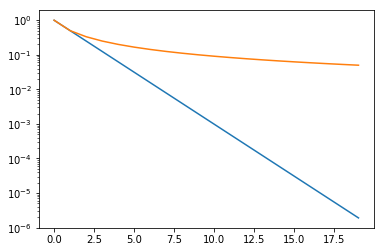

In [655]:
#creation of the tensor : 
Tensor_vf=datacreation(C_size,T_size,Sing_vf)
T_vf=Tensor_vf[0]
Tensor_f=datacreation(C_size,T_size,Sing_f)
T_f=Tensor_f[0]

Text(0.5,1,'Decay of the "diagonal" values')

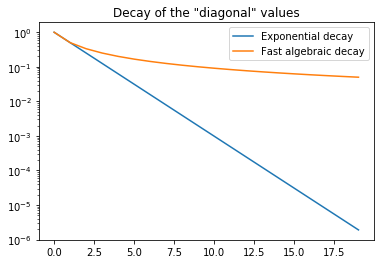

In [656]:
T_vf_diag=Tensor_vf[2]
T_f_diag=Tensor_f[2]
plt.figure()
plt.semilogy(T_vf_diag,label='Exponential decay')
plt.semilogy(T_f_diag,label='Fast algebraic decay')
plt.legend()
plt.title('Decay of the "diagonal" values')

We define a function that get the error, the time and the cost for a target rank r

In [667]:
def get_error(X,r,k,s,q):
    
    dim_array=((r+k,r+s),(r+k,r+s),(r+k,r+s))
    rdim=[r,r,r]

    start=timer()
    T_hosvd=hosvd(X,rdim)
    end=timer()
    t_hosvd=end-start

    start=timer()
    T_STA=STA_tensor(X,dim_array,rdim,mu,sigma)
    end=timer()
    t_s=end-start

    start=timer()
    T_tcyu=tcyu_tensor(X,dim_array,rdim,mu,sigma)
    end=timer()
    t_t=end-start

    start=timer()
    T_hmt=hmt_rank(X,rdim,r+k,q)
    end=timer()
    t_hmt=end-start

    M_hosvd=reconstruct(X,T_hosvd[1])
    M_STA=reconstruct(X,T_STA[1])
    M_tcyu=reconstruct(X,T_tcyu[1])
    M_hmt=reconstruct(X,T_hmt[1])

    e_hosvd=np.linalg.norm(M_hosvd-X)/np.linalg.norm(X)
    e_s=np.linalg.norm(M_STA-X)/np.linalg.norm(X)
    e_t=np.linalg.norm(M_tcyu-X)/np.linalg.norm(X)
    e_hmt=np.linalg.norm(M_hmt-X)/np.linalg.norm(X)

    m=X.shape[0]
    n=m
    m=m**2

    C_svd=cost_hosvd(m,n,r)
    C_sta=cost_sta(m,n,r,k+r,s+r)
    C_tcyu=cost_tcyu(m,n,r,k+r,s+r)
    C_hmt=hmt_cost(m,n,r,k+r,q)
    
    return((e_hosvd,e_s,e_t,e_hmt),(C_svd,C_sta,C_tcyu,C_hmt),(t_hosvd,t_s,t_t,t_hmt))

Then we can implement a function to test the different tensor

In [668]:
def Err_tensor(X,start,finish,k,s,nb):
    #INPUTS : X tensor to approximate (size mxmxm for the cost function), start - finish (starting rank and finish rank), k,s paremeters
    #the dim redux, nb number of run of the algorithm
    #OUPUTS : array with error, array with cost in flops, array with time cost
            
    fin_C_svd=[]
    fin_C_sta=[]
    fin_C_tcyu=[]
    fin_C_hmt=[]

    fin_err_hosvd=[]
    fin_err_sta=[]
    fin_err_tcyu=[]
    fin_err_hmt=[]


    fin_time_hosvd=[]
    fin_time_sta=[]
    fin_time_tcyu=[]
    fin_time_hmt=[]

    mu=0 ; sigma=1 ; q=0;
     
    
    
    for j in range(nb):
        
        err_hosvd=[]
        err_sta=[]
        err_tcyu=[]
        err_hmt=[]
        
        C_svd=[]
        C_sta=[]
        C_tcyu=[]
        C_hmt=[]
        
        time_hosvd=[]
        time_sta=[]
        time_tcyu=[]
        time_hmt=[]
        
        print(j)
              
        for l in range(int(start),int(finish)):
            
                        
            A=get_error(X,l,k,s,q)
            err_array=A[0] ; cost_array=A[1] ; time_array=A[2]
    
            err_hosvd.append(err_array[0])
            err_sta.append(err_array[1])
            err_tcyu.append(err_array[2])
            err_hmt.append(err_array[3])
            
            C_svd.append(cost_array[0])
            C_sta.append(cost_array[1])
            C_tcyu.append(cost_array[2])
            C_hmt.append(cost_array[3])
            
            time_hosvd.append(time_array[0])
            time_sta.append(time_array[1])
            time_tcyu.append(time_array[2])
            time_hmt.append(time_array[3])
        
        fin_C_svd.append(C_svd)
        fin_C_sta.append(C_sta)
        fin_C_tcyu.append(C_tcyu)
        fin_C_hmt.append(C_hmt)
        
        fin_err_hosvd.append(err_hosvd)
        fin_err_sta.append(err_sta)
        fin_err_tcyu.append(err_tcyu)
        fin_err_hmt.append(err_hmt)


        fin_time_hosvd.append(time_hosvd)
        fin_time_sta.append(time_sta)
        fin_time_tcyu.append(time_tcyu)
        fin_time_hmt.append(time_hmt)
        
    E_tcyu=np.mean(fin_err_tcyu,axis=0)
    E_svd=np.mean(fin_err_hosvd,axis=0)
    E_sta=np.mean(fin_err_sta,axis=0)
    E_hmt=np.mean(fin_err_hmt,axis=0)
    
    T_tcyu=np.mean(fin_time_tcyu,axis=0)
    T_svd=np.mean(fin_time_hosvd,axis=0)
    T_sta=np.mean(fin_time_sta,axis=0)
    T_hmt=np.mean(fin_time_hmt,axis=0)
    
    finC_tcyu=np.mean(fin_C_tcyu,axis=0)
    finC_svd=np.mean(fin_C_svd,axis=0)
    finC_sta=np.mean(fin_C_sta,axis=0)
    finC_hmt=np.mean(fin_C_hmt,axis=0)

    
        
    return((E_tcyu,E_svd,E_sta,E_hmt),(T_tcyu,T_svd,T_sta,T_hmt),(finC_tcyu,finC_svd,finC_sta,finC_hmt))

In [669]:
R=Err_tensor(T_vf,3,10,2,4,10)

0
1
2
3
4
5
6
7
8
9


Text(0,0.5,'relative error $err_{rel}$')

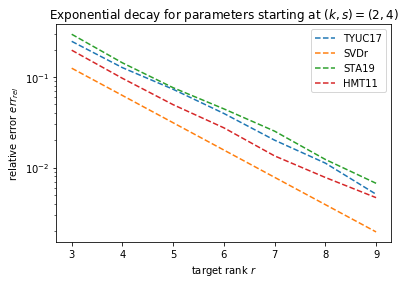

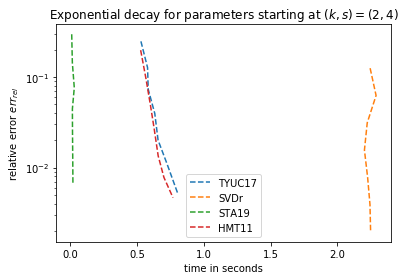

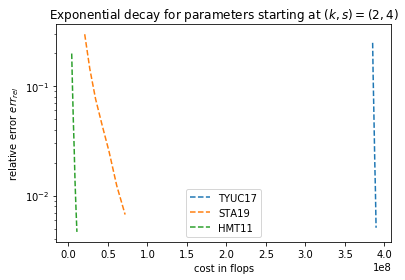

In [670]:
r=[i for i in range(3,10)]
plt.figure()
plt.semilogy(r,R[0][0],'--',label='TYUC17')
plt.semilogy(r,R[0][1],'--',label='SVDr')
plt.semilogy(r,R[0][2],'--',label='STA19')
plt.semilogy(r,R[0][3],'--',label='HMT11')
plt.legend()
plt.title('Exponential decay for parameters starting at $(k,s)=(2,4)$')
plt.xlabel('target rank $r$')
plt.ylabel('relative error $err_{rel}$')

plt.figure()
plt.semilogy(R[1][0],R[0][0],'--',label='TYUC17')
plt.semilogy(R[1][1],R[0][1],'--',label='SVDr')
plt.semilogy(R[1][2],R[0][2],'--',label='STA19')
plt.semilogy(R[1][3],R[0][3],'--',label='HMT11')
plt.legend()
plt.title('Exponential decay for parameters starting at $(k,s)=(2,4)$')
plt.xlabel('time in seconds')
plt.ylabel('relative error $err_{rel}$')


plt.figure()
plt.semilogy(R[2][0],R[0][0],'--',label='TYUC17')
plt.semilogy(R[2][2],R[0][2],'--',label='STA19')
plt.semilogy(R[2][3],R[0][3],'--',label='HMT11')
plt.legend()
plt.title('Exponential decay for parameters starting at $(k,s)=(2,4)$')
plt.xlabel('cost in flops')
plt.ylabel('relative error $err_{rel}$')

In [671]:
R=Err_tensor(T_vf,3,10,4,8,10)

0
1
2
3
4
5
6
7
8
9


Text(0,0.5,'relative error $err_{rel}$')

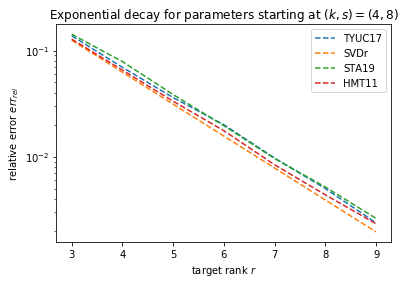

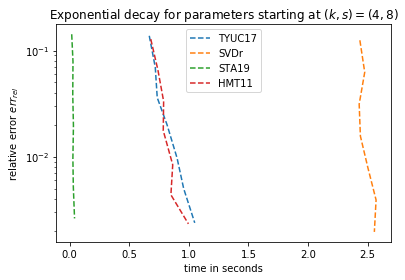

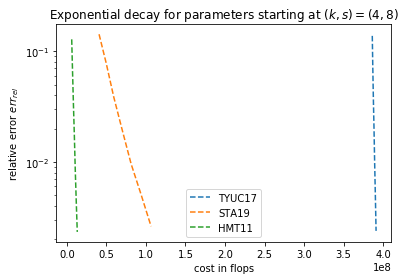

In [672]:
r=[i for i in range(3,10)]
plt.figure()
plt.semilogy(r,R[0][0],'--',label='TYUC17')
plt.semilogy(r,R[0][1],'--',label='SVDr')
plt.semilogy(r,R[0][2],'--',label='STA19')
plt.semilogy(r,R[0][3],'--',label='HMT11')
plt.legend()
plt.title('Exponential decay for parameters starting at $(k,s)=(4,8)$')
plt.xlabel('target rank $r$')
plt.ylabel('relative error $err_{rel}$')

plt.figure()
plt.semilogy(R[1][0],R[0][0],'--',label='TYUC17')
plt.semilogy(R[1][1],R[0][1],'--',label='SVDr')
plt.semilogy(R[1][2],R[0][2],'--',label='STA19')
plt.semilogy(R[1][3],R[0][3],'--',label='HMT11')
plt.legend()
plt.title('Exponential decay for parameters starting at $(k,s)=(4,8)$')
plt.xlabel('time in seconds')
plt.ylabel('relative error $err_{rel}$')


plt.figure()
plt.semilogy(R[2][0],R[0][0],'--',label='TYUC17')
plt.semilogy(R[2][2],R[0][2],'--',label='STA19')
plt.semilogy(R[2][3],R[0][3],'--',label='HMT11')
plt.legend()
plt.title('Exponential decay for parameters starting at $(k,s)=(4,8)$')
plt.xlabel('cost in flops')
plt.ylabel('relative error $err_{rel}$')

In [673]:
R=Err_tensor(T_f,3,10,2,4,10)

0
1
2
3
4
5
6
7
8
9


Text(0,0.5,'relative error $err_{rel}$')

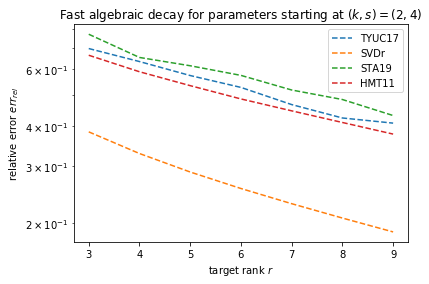

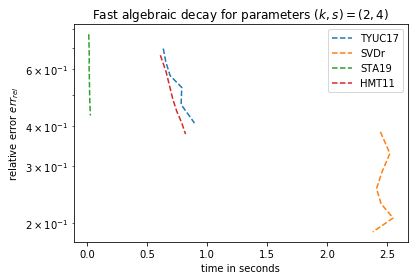

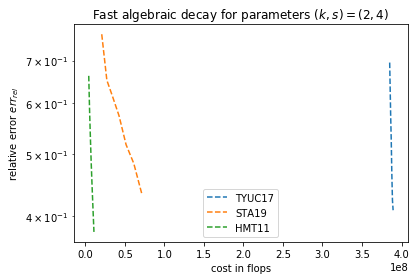

In [674]:
r=[i for i in range(3,10)]
plt.figure()
plt.semilogy(r,R[0][0],'--',label='TYUC17')
plt.semilogy(r,R[0][1],'--',label='SVDr')
plt.semilogy(r,R[0][2],'--',label='STA19')
plt.semilogy(r,R[0][3],'--',label='HMT11')
plt.legend()
plt.title('Fast algebraic decay for parameters starting at $(k,s)=(2,4)$')
plt.xlabel('target rank $r$')
plt.ylabel('relative error $err_{rel}$')

plt.figure()
plt.semilogy(R[1][0],R[0][0],'--',label='TYUC17')
plt.semilogy(R[1][1],R[0][1],'--',label='SVDr')
plt.semilogy(R[1][2],R[0][2],'--',label='STA19')
plt.semilogy(R[1][3],R[0][3],'--',label='HMT11')
plt.legend()
plt.title('Fast algebraic decay for parameters $(k,s)=(2,4)$')
plt.xlabel('time in seconds')
plt.ylabel('relative error $err_{rel}$')


plt.figure()
plt.semilogy(R[2][0],R[0][0],'--',label='TYUC17')
plt.semilogy(R[2][2],R[0][2],'--',label='STA19')
plt.semilogy(R[2][3],R[0][3],'--',label='HMT11')
plt.legend()
plt.title('Fast algebraic decay for parameters $(k,s)=(2,4)$')
plt.xlabel('cost in flops')
plt.ylabel('relative error $err_{rel}$')

In [675]:
R=Err_tensor(T_f,3,10,4,8,10)

0
1
2
3
4
5
6
7
8
9


Text(0,0.5,'relative error $err_{rel}$')

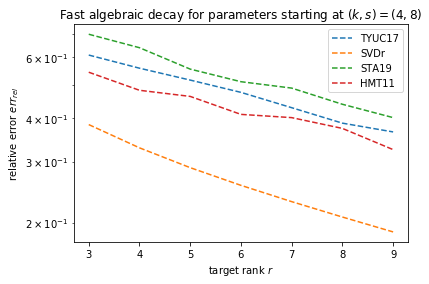

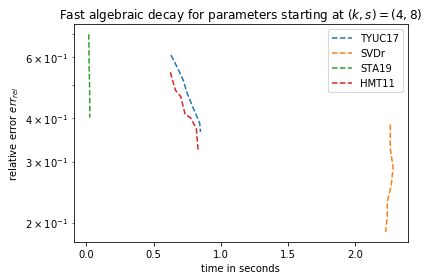

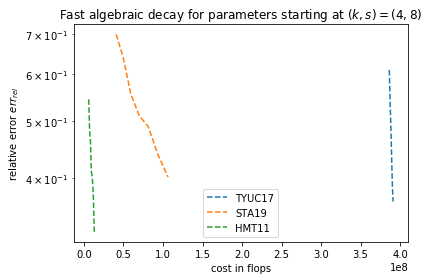

In [676]:
r=[i for i in range(3,10)]
plt.figure()
plt.semilogy(r,R[0][0],'--',label='TYUC17')
plt.semilogy(r,R[0][1],'--',label='SVDr')
plt.semilogy(r,R[0][2],'--',label='STA19')
plt.semilogy(r,R[0][3],'--',label='HMT11')
plt.legend()
plt.title('Fast algebraic decay for parameters starting at $(k,s)=(4,8)$')
plt.xlabel('target rank $r$')
plt.ylabel('relative error $err_{rel}$')

plt.figure()
plt.semilogy(R[1][0],R[0][0],'--',label='TYUC17')
plt.semilogy(R[1][1],R[0][1],'--',label='SVDr')
plt.semilogy(R[1][2],R[0][2],'--',label='STA19')
plt.semilogy(R[1][3],R[0][3],'--',label='HMT11')
plt.legend()
plt.title('Fast algebraic decay for parameters starting at $(k,s)=(4,8)$')
plt.xlabel('time in seconds')
plt.ylabel('relative error $err_{rel}$')


plt.figure()
plt.semilogy(R[2][0],R[0][0],'--',label='TYUC17')
plt.semilogy(R[2][2],R[0][2],'--',label='STA19')
plt.semilogy(R[2][3],R[0][3],'--',label='HMT11')
plt.legend()
plt.title('Fast algebraic decay for parameters starting at $(k,s)=(4,8)$')
plt.xlabel('cost in flops')
plt.ylabel('relative error $err_{rel}$')

___